In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from scipy.spatial import procrustes
from scipy.spatial.distance import jensenshannon

In [2]:
plt.style.use('ggplot')

In [3]:
data=pd.read_csv('combined_data_with_loc.csv')
data.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.242641,4.242641e+00
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.238795,3.826834e+00
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,2.700000e+01
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,28.000000,1.714506e-15
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,1.200000e+01


In [4]:
#load feature category mapping
feature_category_dict=json.load(open('feature_category_dict.json'))
feature_category_dict

{'2007 population': ['2007 ERP age 0-4, persons',
  '2007 ERP age 0-4, %',
  '2007 ERP age 5-9, persons',
  '2007 ERP age 5-9, %',
  '2007 ERP age 10-14, persons',
  '2007 ERP age 10-14, %',
  '2007 ERP age 15-19, persons',
  '2007 ERP age 15-19, %',
  '2007 ERP age 20-24, persons',
  '2007 ERP age 20-24, %',
  '2007 ERP age 25-44, persons',
  '2007 ERP age 25-44, %',
  '2007 ERP age 45-64, persons',
  '2007 ERP age 45-64, %',
  '2007 ERP age 65-69, persons',
  '2007 ERP age 65-69, %',
  '2007 ERP age 70-74, persons',
  '2007 ERP age 70-74, %',
  '2007 ERP age 75-79, persons',
  '2007 ERP age 75-79, %',
  '2007 ERP age 80-84, persons',
  '2007 ERP age 80-84, %',
  '2007 ERP age 85+, persons',
  '2007 ERP age 85+, %',
  '2007 ERP, total'],
 '2007-2012 population change': ['% change, 2007-2012, age 0-4',
  '% change, 2007-2012, age 5-9',
  '% change, 2007-2012, age 10-14',
  '% change, 2007-2012, age 15-19',
  '% change, 2007-2012, age 20-24',
  '% change, 2007-2012, age 25-44',
  '% cha

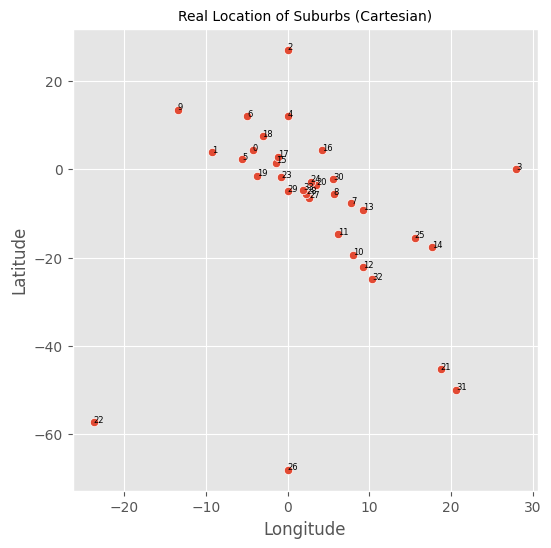

In [5]:
# do a similar plot for the real location of the suburbs
plt.figure(figsize=(6,6))
sns.scatterplot(x='cart_x',y='cart_y',data=data)
plt.title('Real Location of Suburbs (Cartesian)',fontsize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# annotate the suburbs with the suburb index
for i in range(data.shape[0]):
	plt.text(data['cart_x'].iloc[i],data['cart_y'].iloc[i],i,fontsize=6)
plt.show()
# print the stress of the MDS



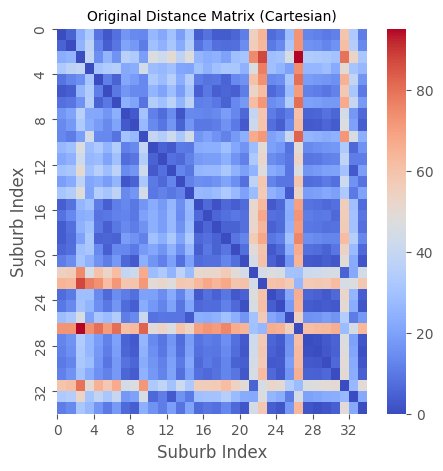

In [6]:
# pairwise distance between the original location
distance_original=np.zeros((data.shape[0],data.shape[0]))
for i in range(data.shape[0]):
	for j in range(data.shape[0]):
		distance_original[i,j]=np.sqrt((data['cart_x'].iloc[i]-data['cart_x'].iloc[j])**2+(data['cart_y'].iloc[i]-data['cart_y'].iloc[j])**2)

# plot the distance matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_original,cmap='coolwarm')
plt.title('Original Distance Matrix (Cartesian)',fontsize=10)
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# ticks every 4th
plt.xticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.yticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))

plt.show()

# Perspective 1: Services Provided

In [7]:
# load the category 'Services'
category='Services'
features=feature_category_dict[category]
features

['Public Hospitals',
 'Private Hospitals',
 'Community Health Centres',
 'Bush Nursing Centres',
 'Allied Health',
 'Alternative Health',
 'Child Protection and Family',
 'Dental',
 'Disability',
 'General Practice',
 'Homelessness',
 'Mental Health',
 'Pharmacies',
 'Aged Care (High Care)',
 'Aged Care (Low Care)',
 'Aged Care (SRS)',
 'Kinder and/or Childcare',
 'Primary Schools',
 'Secondary Schools',
 'P12 Schools',
 'Other Schools',
 'Centrelink Offices',
 'Medicare Offices',
 'Medicare Access Points']

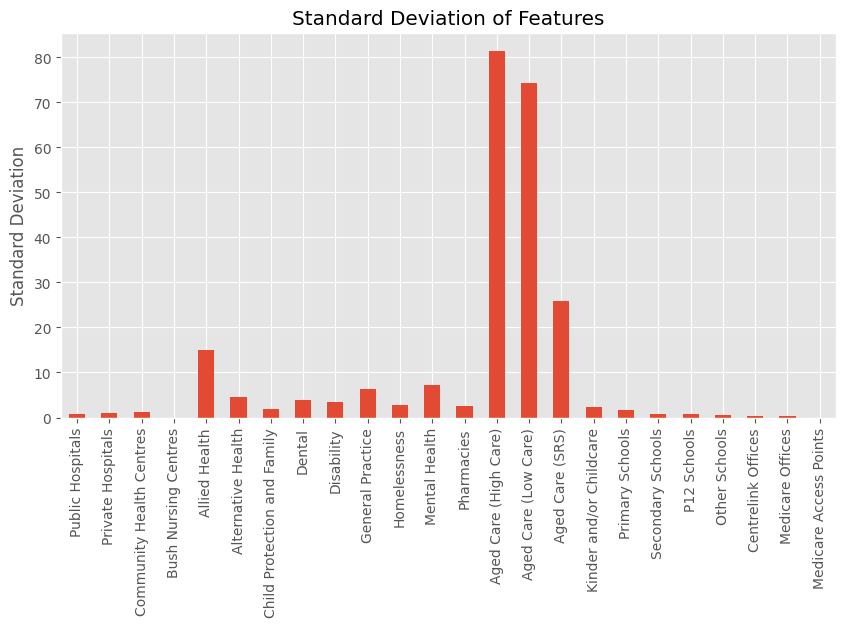

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0


In [8]:
# extract the data for the category 'Services'
data_services=data[features]
# plot the standard deviation of the features
plt.figure(figsize=(10,5))
data_services.std().plot(kind='bar')
plt.title('Standard Deviation of Features')
plt.ylabel('Standard Deviation')
plt.show()
data_services.head()

In [9]:
# scale the data between 0 and 1
scaler=MinMaxScaler()
data_services_scaled=scaler.fit_transform(data_services)
data_services_scaled=pd.DataFrame(data_services_scaled,columns=features)
data_services_scaled.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.0,0.000000,0.000000,0.074074,...,0.110714,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.076923,0.148148,...,0.000000,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.0,0.066667,0.076923,0.296296,...,0.000000,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.0,0.466667,0.692308,0.333333,...,0.639286,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.000000,0.185185,...,0.535714,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0


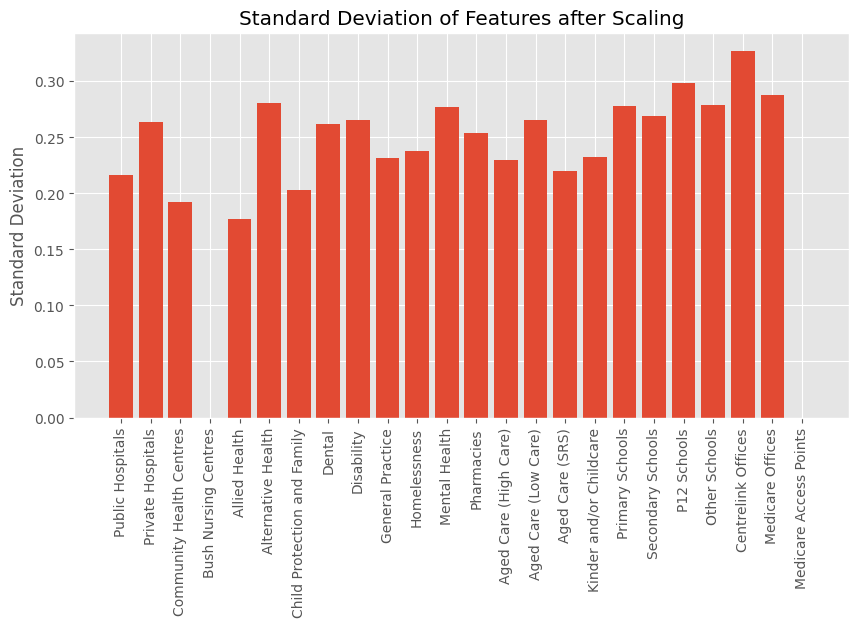

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
count,34.000000,34.000000,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0
mean,0.066176,0.183824,0.102941,0.0,0.160208,0.237132,0.068627,0.239216,0.233032,0.232026,...,0.248739,0.110419,0.261765,0.387255,0.225490,0.186275,0.205882,0.117647,0.088235,0.0
std,0.215927,0.263347,0.192514,0.0,0.176910,0.280683,0.202887,0.261628,0.265448,0.231442,...,0.265606,0.219691,0.232268,0.277436,0.268687,0.298043,0.278460,0.327035,0.287902,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0,0.064706,0.000000,0.000000,0.016667,0.019231,0.074074,...,0.000000,0.000000,0.100000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0,0.141176,0.125000,0.000000,0.133333,0.153846,0.185185,...,0.169643,0.000000,0.200000,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.250000,0.166667,0.0,0.197059,0.406250,0.000000,0.400000,0.307692,0.287037,...,0.418750,0.165254,0.400000,0.500000,0.333333,0.333333,0.500000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [10]:
# plot the standard deviation of the features
plt.figure(figsize=(10,5))
plt.bar(data_services_scaled.columns,data_services_scaled.std())
plt.xticks(rotation=90)
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Features after Scaling')
plt.show()
data_services_scaled.describe()

In [11]:
data_services_scaled['suburb_services_score']=data_services_scaled.mean(axis=1)
data_services_scaled.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points,suburb_services_score
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.0,0.000000,0.000000,0.074074,...,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.124661
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.076923,0.148148,...,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0,0.107885
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.0,0.066667,0.076923,0.296296,...,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.133961
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.0,0.466667,0.692308,0.333333,...,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0,0.318122
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.000000,0.185185,...,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.139885


<Figure size 1000x500 with 0 Axes>

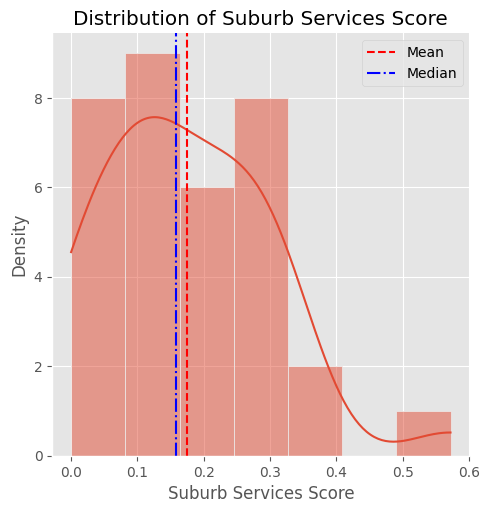

count    34.000000
mean      0.174807
std       0.127465
min       0.000000
25%       0.089691
50%       0.157910
75%       0.258785
max       0.572092
Name: suburb_services_score, dtype: float64

In [12]:
# plot the distribution of the suburb services score
plt.figure(figsize=(10,5))
sns.displot(data_services_scaled['suburb_services_score'],kde=True)
plt.title('Distribution of Suburb Services Score')
plt.xlabel('Suburb Services Score')
plt.ylabel('Density')
# show mean and median
plt.axvline(data_services_scaled['suburb_services_score'].mean(),color='red',label='Mean',linestyle='--')
plt.axvline(data_services_scaled['suburb_services_score'].median(),color='blue',label='Median',linestyle='-.')
plt.legend()
plt.show()
# describe the suburb services score
data_services_scaled['suburb_services_score'].describe()

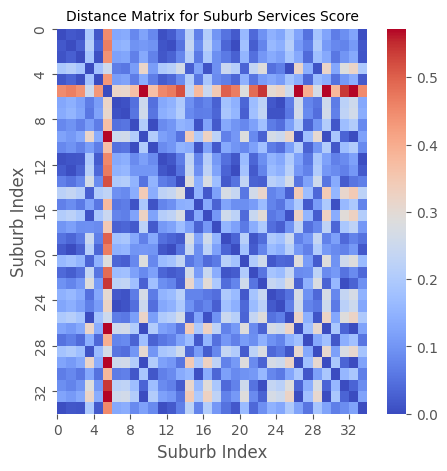

In [13]:
# define distance between two suburbs
# value is (absolute difference between the two suburb services scores)
def similarity_score(suburb1_idx,suburb2_idx):
	return np.abs(data_services_scaled['suburb_services_score'][suburb1_idx]-data_services_scaled['suburb_services_score'][suburb2_idx])

# calculate similarity matrix
distance_services=np.zeros((data_services_scaled.shape[0],data_services_scaled.shape[0]))
for i in range(data_services_scaled.shape[0]):
	for j in range(data_services_scaled.shape[0]):
		distance_services[i,j]=similarity_score(i,j)

# plot the similarity matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_services,cmap='coolwarm')
plt.title('Distance Matrix for Suburb Services Score',fontsize=10)
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# tick every 4
plt.xticks(np.arange(0,data_services_scaled.shape[0],4),np.arange(0,data_services_scaled.shape[0],4))
plt.yticks(np.arange(0,data_services_scaled.shape[0],4),np.arange(0,data_services_scaled.shape[0],4))
plt.show()

Correlation between 2D distances and Services distances: 0.999500118075889
Procrustes Disparity between 2D distances and Services distances: 0.0006810474580765952
Stress of the MDS: 0.01049833971993749


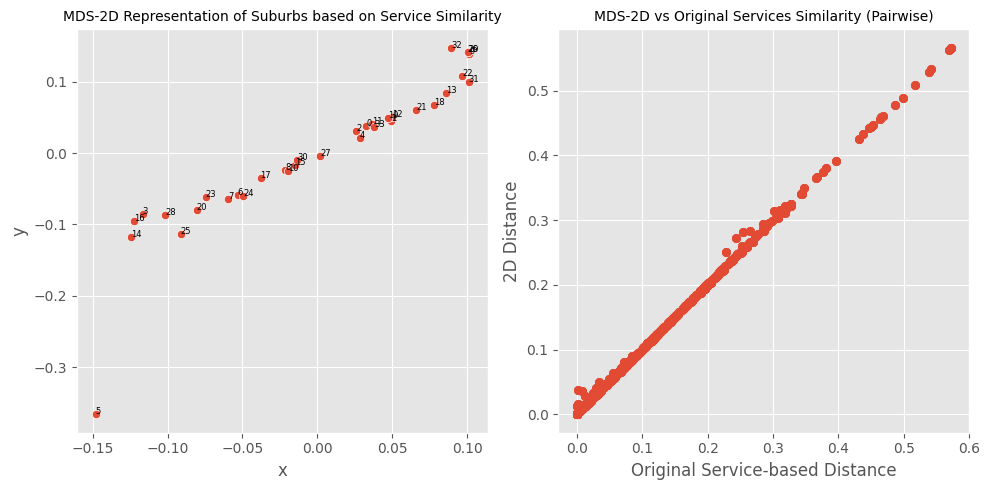

In [14]:
# Perform MDS on the similarity matrix to get the 2D representation of the suburbs
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
suburb_2d_services = mds.fit_transform(distance_services)
suburb_2d_services = pd.DataFrame(suburb_2d_services, columns=['x', 'y'])

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 2D representation of the suburbs in the first subplot
sns.scatterplot(x='x', y='y', data=suburb_2d_services, ax=axes[0])
axes[0].set_title("MDS-2D Representation of Suburbs based on Service Similarity", fontsize=10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Annotate the suburbs with the suburb index
for i in range(suburb_2d_services.shape[0]):
	axes[0].text(suburb_2d_services['x'].iloc[i], suburb_2d_services['y'].iloc[i], i, fontsize=6)

# Compute pairwise distances in the 2D representation
distances_2d_services = np.zeros((suburb_2d_services.shape[0], suburb_2d_services.shape[0]))
for i in range(suburb_2d_services.shape[0]):
	for j in range(suburb_2d_services.shape[0]):
		distances_2d_services[i, j] = np.sqrt(
			(suburb_2d_services['x'].iloc[i] - suburb_2d_services['x'].iloc[j])**2 +
			(suburb_2d_services['y'].iloc[i] - suburb_2d_services['y'].iloc[j])**2
		)

# Compute correlation between the pairwise distances in the 2D representation and the original distances
correlation = np.corrcoef(distance_services.flatten(), distances_2d_services.flatten())[0, 1]
print(f'Correlation between 2D distances and Services distances: {correlation}')

# Compute Procrustes analysis for the original and 2D representation
mtx1, mtx2, disparity = procrustes(distance_services, distances_2d_services)
print(f'Procrustes Disparity between 2D distances and Services distances: {disparity}')

# print the stress of the MDS
print(f'Stress of the MDS: {mds.stress_}')

# Plot the 2D distances vs original distances in the second subplot
axes[1].scatter(distance_services.flatten(), distances_2d_services.flatten())
axes[1].set_xlabel('Original Service-based Distance')
axes[1].set_ylabel('2D Distance')
axes[1].set_title('MDS-2D vs Original Services Similarity (Pairwise)', fontsize=10)

data['suburb_services_score']=data_services_scaled['suburb_services_score']

# Show the combined plot
plt.tight_layout()
plt.show()


In [15]:
# compute the correlation matrix for the two 2D representations
from scipy.spatial import procrustes

# Example distance matrices
matrix1 = distance_services
matrix2 = distance_original

# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(matrix1, matrix2)
print(f"Procrustes Disparity between Cartesian based distance matrix and Services based distance matrix: {disparity}")


Procrustes Disparity between Cartesian based distance matrix and Services based distance matrix: 0.8687853719727332


# Perspective 2: 2012 Population Age Distribution

In [16]:
feature='2012 population'
data_population=data[feature_category_dict[feature]]
# check for missing values
missing_values=data_population.isnull().sum()
print(f'Missing values in the data: {missing_values.sum()}')
data_population.head()

Missing values in the data: 0


,"2012 ERP age 0-4, persons","2012 ERP age 0-4, %","2012 ERP age 5-9, persons","2012 ERP age 5-9, %","2012 ERP age 10-14, persons","2012 ERP age 10-14, %","2012 ERP age 15-19, persons","2012 ERP age 15-19, %","2012 ERP age 20-24, persons","2012 ERP age 20-24, %",...,"2012 ERP age 65-69, %","2012 ERP age 70-74, persons","2012 ERP age 70-74, %","2012 ERP age 75-79, persons","2012 ERP age 75-79, %","2012 ERP age 80-84, persons","2012 ERP age 80-84, %","2012 ERP age 85+, persons","2012 ERP age 85+, %","2012 ERP, total"
0,1135,7.873196,804,5.577137,619,4.293840,575,3.988624,1229,8.525250,...,3.024417,344,2.386238,274,1.900666,234,1.623196,191,1.324917,14416
1,700,7.990868,562,6.415525,509,5.810502,598,6.826484,801,9.143836,...,2.625571,205,2.340183,189,2.157534,150,1.712329,109,1.244292,8760
2,3590,9.822430,2964,8.109661,2670,7.305261,2658,7.272429,2808,7.682837,...,1.991847,458,1.253112,277,0.757887,165,0.451449,72,0.196996,36549
3,1601,6.519526,1309,5.330456,1197,4.874374,1360,5.538136,1607,6.543959,...,4.996539,972,3.958138,798,3.249583,772,3.143706,790,3.217005,24557
4,950,7.134275,922,6.924001,815,6.120457,780,5.857615,869,6.525984,...,3.702313,574,4.310604,643,4.828777,569,4.273055,455,3.416942,13316


In [17]:
# select the columns with '%' symbol
data_population_percentage=data_population.loc[:,data_population.columns.str.contains('%')]
data_population_percentage.head()

,"2012 ERP age 0-4, %","2012 ERP age 5-9, %","2012 ERP age 10-14, %","2012 ERP age 15-19, %","2012 ERP age 20-24, %","2012 ERP age 25-44, %","2012 ERP age 45-64, %","2012 ERP age 65-69, %","2012 ERP age 70-74, %","2012 ERP age 75-79, %","2012 ERP age 80-84, %","2012 ERP age 85+, %"
0,7.873196,5.577137,4.293840,3.988624,8.525250,37.007492,22.475028,3.024417,2.386238,1.900666,1.623196,1.324917
1,7.990868,6.415525,5.810502,6.826484,9.143836,33.207763,20.525114,2.625571,2.340183,2.157534,1.712329,1.244292
2,9.822430,8.109661,7.305261,7.272429,7.682837,35.568689,19.587403,1.991847,1.253112,0.757887,0.451449,0.196996
3,6.519526,5.330456,4.874374,5.538136,6.543959,28.989697,23.638881,4.996539,3.958138,3.249583,3.143706,3.217005
4,7.134275,6.924001,6.120457,5.857615,6.525984,28.086512,18.819465,3.702313,4.310604,4.828777,4.273055,3.416942


In [18]:
# convert percentage to float
data_population_frac=data_population_percentage/100
for col in data_population_frac.columns:
	data_population_frac[col]=data_population_frac[col].astype(float)
	# change the column name
	# data_population_frac.rename(columns={col:col.replace('%','frac')},inplace=True)

# print if all the rows sum to 1
all_rows_sum_to_1=True
for i in range(data_population_frac.shape[0]):
	if not np.isclose(data_population_frac.iloc[i].sum(),1):
		all_rows_sum_to_1=False
		print(f'Row {i} does not sum to 1')

if all_rows_sum_to_1:
	print('All rows sum to 1')
	

All rows sum to 1


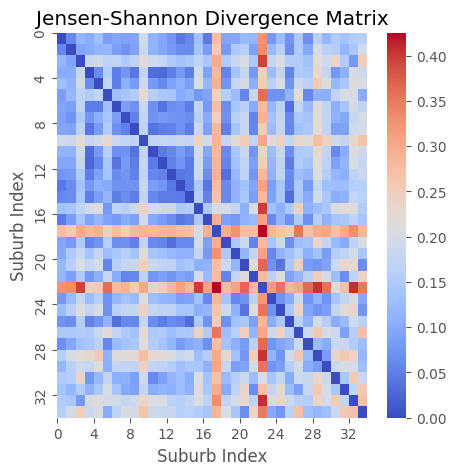

In [19]:
# compute the distance matrix in terms of Jensen-Shannon Divergence
distance_population_frac = np.zeros((data_population_frac.shape[0], data_population_frac.shape[0]))
for i in range(data_population_frac.shape[0]):
	for j in range(data_population_frac.shape[0]):
		distance_population_frac[i, j] = jensenshannon(data_population_frac.iloc[i], data_population_frac.iloc[j])

# plot the distance matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_population_frac,cmap='coolwarm')
plt.title('Jensen-Shannon Divergence Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# ticks every 4th
plt.xticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.yticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.show()

Correlation between 2D distances and Population Fraction distances: 0.940692895605369
Procrustes Disparity between 2D distances and Population Fraction distances: 0.11745265478578235
Stress of the MDS: 0.5746662941600144


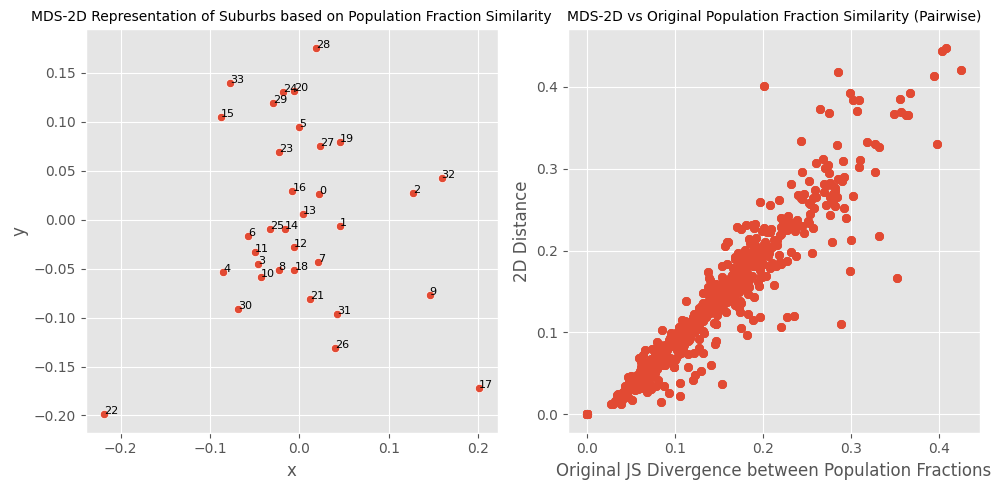

In [20]:
# Perform MDS on the similarity matrix to get the 2D representation of the suburbs
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
suburb_2d_population_frac = mds.fit_transform(distance_population_frac)
suburb_2d_population_frac = pd.DataFrame(suburb_2d_population_frac, columns=['x', 'y'])

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 2D representation of the suburbs in the first subplot
sns.scatterplot(x='x', y='y', data=suburb_2d_population_frac, ax=axes[0])
axes[0].set_title('MDS-2D Representation of Suburbs based on Population Fraction Similarity', fontsize=10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Annotate the suburbs with the suburb index
for i in range(suburb_2d_population_frac.shape[0]):
	axes[0].text(suburb_2d_population_frac['x'].iloc[i], suburb_2d_population_frac['y'].iloc[i], i, fontsize=8)

# Compute pairwise distances in the 2D representation
distances_2d_population_frac = np.zeros((suburb_2d_population_frac.shape[0], suburb_2d_population_frac.shape[0]))
for i in range(suburb_2d_population_frac.shape[0]):
	for j in range(suburb_2d_population_frac.shape[0]):
		distances_2d_population_frac[i, j] = np.sqrt(
			(suburb_2d_population_frac['x'].iloc[i] - suburb_2d_population_frac['x'].iloc[j])**2 +
			(suburb_2d_population_frac['y'].iloc[i] - suburb_2d_population_frac['y'].iloc[j])**2
		)

# Compute correlation between the pairwise distances in the 2D representation and the original distances
correlation = np.corrcoef(distance_population_frac.flatten(), distances_2d_population_frac.flatten())[0, 1]
print(f'Correlation between 2D distances and Population Fraction distances: {correlation}')

# Compute Procrustes analysis for the original and 2D representation
mtx1, mtx2, disparity = procrustes(distance_population_frac, distances_2d_population_frac)
print(f'Procrustes Disparity between 2D distances and Population Fraction distances: {disparity}')

# print the stress of the MDS
print(f'Stress of the MDS: {mds.stress_}')

# Plot the 2D distances vs original distances in the second subplot
axes[1].scatter(distance_population_frac.flatten(), distances_2d_population_frac.flatten())
axes[1].set_xlabel('Original JS Divergence between Population Fractions')
axes[1].set_ylabel('2D Distance')
axes[1].set_title('MDS-2D vs Original Population Fraction Similarity (Pairwise)', fontsize=10)

# Show the combined plot
plt.tight_layout()
plt.show()

In [21]:
# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(distance_population_frac, distance_original)
print(f"Procrustes Disparity between Population Fraction based distance matrix and Cartesian based distance matrix: {disparity}")


Procrustes Disparity between Population Fraction based distance matrix and Cartesian based distance matrix: 0.746869351439009


# A2: Post Metric Analysis

# Spectral Clustering Based on Metric-Specific Distances

## Spectral Clustering on Services

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import SpectralClustering

spectral_distance_services = np.exp(-distance_services)  # affinity matrix
spectral_distance_population_frac = np.exp(-distance_population_frac)

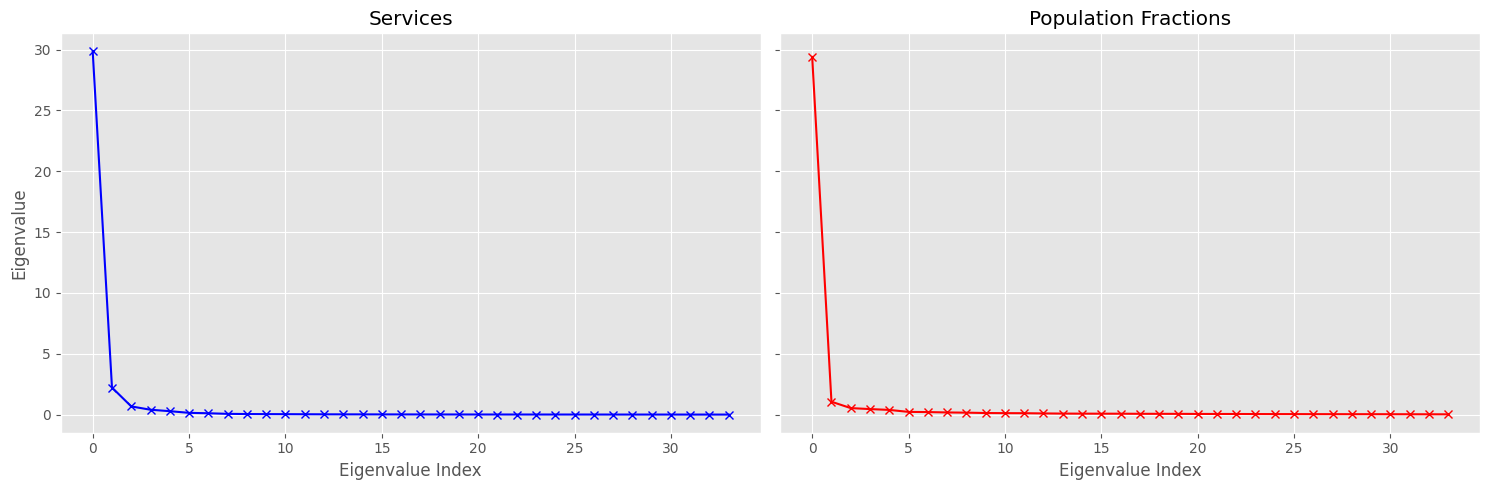

In [23]:
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Compute the eigenvalues and eigenvectors (assuming the spectral_distance_* matrices are defined)
eigenvalues_services, eigenvectors_services = eigh(spectral_distance_services)
eigenvalues_population_frac, eigenvectors_population_frac = eigh(spectral_distance_population_frac)

# Create subplots in a single figure
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot eigenvalues for services
axes[0].plot(eigenvalues_services[::-1], label='Services', color='blue', marker='x')
axes[0].set_title('Services')
axes[0].set_xlabel('Eigenvalue Index')
axes[0].set_ylabel('Eigenvalue')


# Plot eigenvalues for population fractions
axes[1].plot(eigenvalues_population_frac[::-1], label='Population Fractions', color='red', marker='x')
axes[1].set_title('Population Fractions')
axes[1].set_xlabel('Eigenvalue Index')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### Elbow for both at $k=3$

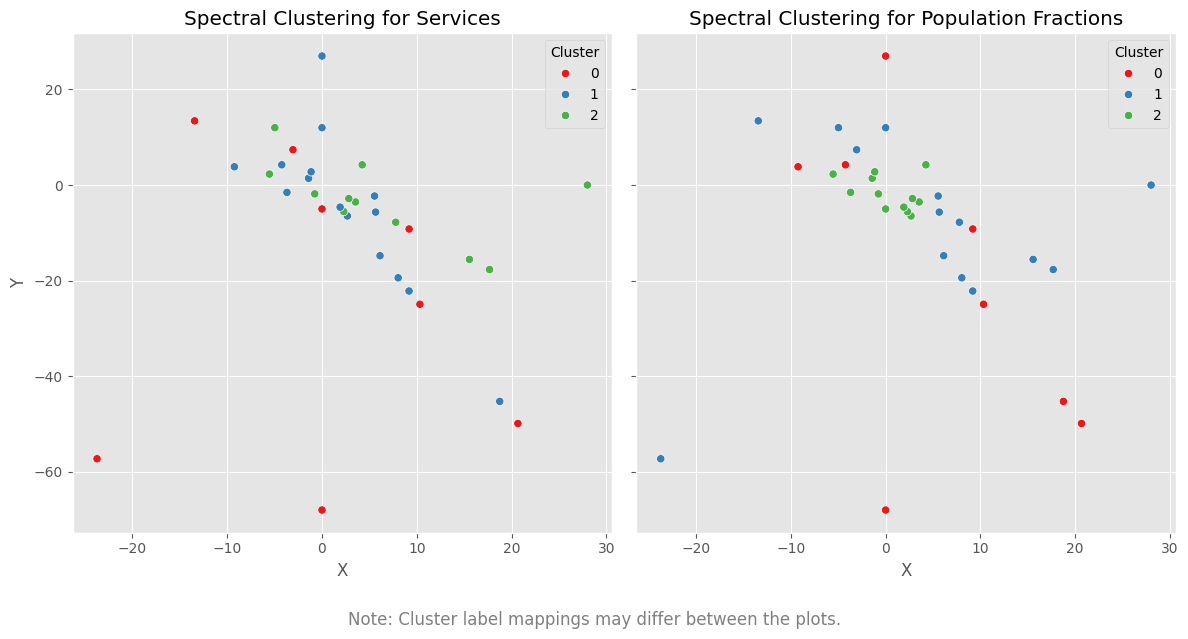

In [24]:
# Assuming 'data' and distance matrices (distance_services, distance_land_frac, distance_population_frac) are defined

# Spectral clustering for Services
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
spectral.fit(spectral_distance_services)
data['spectral_cluster_services'] = spectral.labels_


# Spectral clustering for Population Fractions
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
spectral.fit(spectral_distance_population_frac)
data['spectral_cluster_population_frac'] = spectral.labels_

# Create subplots for the clustering results
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot clustering for Services
sns.scatterplot(
	ax=axes[0], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_services', palette='Set1'
)
axes[0].set_title('Spectral Clustering for Services')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend(title='Cluster', loc='upper right')


# Plot clustering for Population Fractions
sns.scatterplot(
	ax=axes[1], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_population_frac', palette='Set1'
)
axes[1].set_title('Spectral Clustering for Population Fractions')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend(title='Cluster', loc='upper right')

# Add a note at the bottom of the figure
fig.text(0.5, -0.05, 'Note: Cluster label mappings may differ between the plots.', 
		 ha='center', fontsize=12, color='gray')

# Adjust layout
plt.tight_layout()
plt.show()


### Hungarian Mapping for alignment

In [25]:
# Apply Hungarian algorithm to find the best label matching between the clusters

from scipy.optimize import linear_sum_assignment

# Define a function to find the best label matching
def find_best_label_matching(true_labels, predicted_labels):
	cost_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(predicted_labels))))
	
	for i, true_label in enumerate(np.unique(true_labels)):
		true_mask = true_labels == true_label
		for j, predicted_label in enumerate(np.unique(predicted_labels)):
			predicted_mask = predicted_labels == predicted_label
			cost_matrix[i, j] = np.sum(np.logical_and(true_mask, predicted_mask))
	
	row_ind, col_ind = linear_sum_assignment(-cost_matrix)
	return col_ind


# Find the best label matching for Population Fractions
label_matching_population_frac = find_best_label_matching(data['spectral_cluster_population_frac'], data['spectral_cluster_services'])
data['spectral_cluster_population_frac_matched'] = data['spectral_cluster_population_frac'].map({i: j for i, j in enumerate(label_matching_population_frac)})
data['spectral_cluster_population_frac_matched'] = data['spectral_cluster_population_frac_matched'].astype(int)


print('Best Label Matching for Population Fractions and Services:')
print(label_matching_population_frac)

Best Label Matching for Population Fractions and Services:
[0 1 2]


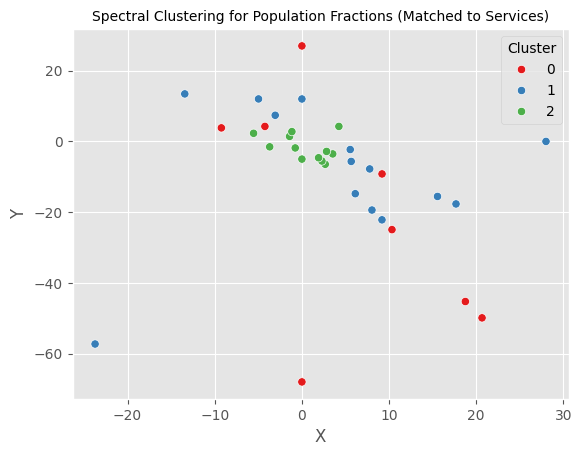

In [26]:
# re-plot the clustering results
# Create subplots for the clustering results



# Plot clustering for Population Fractions
sns.scatterplot(
	x='cart_x', y='cart_y', data=data, hue='spectral_cluster_population_frac_matched', palette='Set1'
)
plt.title('Spectral Clustering for Population Fractions (Matched to Services)', fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [27]:
# find the indices of the groupwise matches

matches_services_population_frac = np.where(data['spectral_cluster_services'] == data['spectral_cluster_population_frac'])[0]


# find the number of pairwise matches
num_matches_services_population_frac = np.sum(data['spectral_cluster_services'] == data['spectral_cluster_population_frac'])


# print the number of pairwise matches
print(f'Number of pairwise matches between Services and Population Fractions: {num_matches_services_population_frac}')

# print the number of pairwise matches for each group
print(f'Index of pairwise matches for each group between Services and Population Fractions: {matches_services_population_frac}')




########################

print('-----------------------------------')


# compute pairwise NMI between the clusters
from sklearn.metrics import normalized_mutual_info_score as NMI

nmi_services_population_frac = NMI(data['spectral_cluster_services'], data['spectral_cluster_population_frac'])


# compute ARIs
from sklearn.metrics import adjusted_rand_score as ARI

ari_services_population_frac = ARI(data['spectral_cluster_services'], data['spectral_cluster_population_frac'])

# print the pairwise NMI
print(f'Pairwise NMI between Services and Population Fractions: {nmi_services_population_frac}')

# print the ARIs
print(f'ARI between Services and Population Fractions: {ari_services_population_frac}')


Number of pairwise matches between Services and Population Fractions: 16
Index of pairwise matches for each group between Services and Population Fractions: [ 4  5  8 10 11 12 13 16 20 23 24 26 28 30 31 32]
-----------------------------------
Pairwise NMI between Services and Population Fractions: 0.13314228249522692
ARI between Services and Population Fractions: 0.024124329780303953


In [28]:
# compute pairwise procrustes disparity
disparity_metrics_pairs = np.zeros((2, 2))
dist_metrics=[distance_services,distance_population_frac]
for i in range(2):
	for j in range(2):
		_, _, disparity_metrics_pairs[i, j] = procrustes(dist_metrics[i], dist_metrics[j])


# print the pairwise procrustes disparity
print('Pairwise Procrustes Disparity:')
print(np.round(disparity_metrics_pairs, 5))
# print the mapping dictionary for the metrics
print('\n')
print('Mapping Dictionary:')
print({
	0: 'Services',
	1: 'Population Fractions'
})


Pairwise Procrustes Disparity:
[[0.      0.89249]
 [0.89249 0.     ]]


Mapping Dictionary:
{0: 'Services', 1: 'Population Fractions'}


# Tobler's Law

## Services Score

Largest distance between the points: 95.0 km
Pairwise Distance Statistics:
DescribeResult(nobs=1156, minmax=(np.float64(0.0), np.float64(95.0)), mean=np.float64(24.560775147753063), variance=np.float64(394.03879834548684), skewness=np.float64(1.0264081064228707), kurtosis=np.float64(0.2480576102140546))


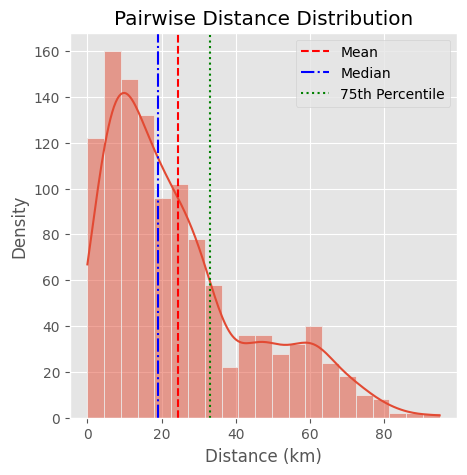

In [29]:
import scipy.stats as stats
# compute pairwise distances between the between the points
distance_pairwise = np.zeros((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        distance_pairwise[i, j] = np.sqrt(
            (data['cart_x'].iloc[i] - data['cart_x'].iloc[j])**2 +
            (data['cart_y'].iloc[i] - data['cart_y'].iloc[j])**2
        )

# compute the largest distance between the points
max_distance = np.max(distance_pairwise)
print(f'Largest distance between the points: {max_distance} km')
# describe the pairwise distances
print('Pairwise Distance Statistics:')
# don't use dataframe, use scipy stats
print(stats.describe(distance_pairwise.flatten()))

# show sns.distplot
plt.figure(figsize=(5, 5))
sns.histplot(distance_pairwise.flatten(), kde=True)
plt.title('Pairwise Distance Distribution')
plt.xlabel('Distance (km)')
plt.ylabel('Density')
# show mean and median using vertical lines
plt.axvline(np.mean(distance_pairwise.flatten()), color='red', label='Mean', linestyle='--')
plt.axvline(np.median(distance_pairwise.flatten()), color='blue', label='Median', linestyle='-.')
pairwise_distance_mean = np.mean(distance_pairwise.flatten())
pairwise_distance_median = np.median(distance_pairwise.flatten())
# 75th percentile
plt.axvline(np.percentile(distance_pairwise.flatten(), 75), color='green', label='75th Percentile', linestyle=':')
pairwise_distance_75th_percentile = np.percentile(distance_pairwise.flatten(), 75)
plt.legend()
plt.show()



Effective Range: 5.289567439268893


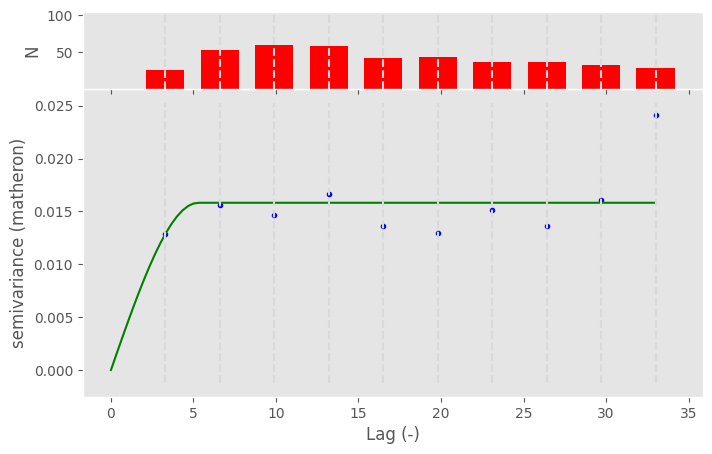

Full Description: {'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(174.55572549587347), 'normalized_sill': np.float64(0.0003807874331520487), 'normalized_nugget': 0, 'effective_range': np.float64(5.289567439268893), 'sill': np.float64(0.015816432624578703), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': np.float64(33.0), 'n_lags': 10, 'verbose': False}, 'kwargs': {}}


In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from esda import Moran, Geary, G_Local
import matplotlib.pyplot as plt
# set warning to ignore
import warnings
warnings.filterwarnings("ignore")


# plot variogram
gdf=gpd.GeoDataFrame(data,geometry=gpd.points_from_xy(data['cart_x'],data['cart_y']))
from skgstat import Variogram
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
values = data['suburb_services_score']
variogram = Variogram(
    coordinates=coords, 
    values=values, 
    maxlag=pairwise_distance_75th_percentile,  # Optional: can be adjusted based on your dataset, such as 'median'
    n_lags=10,  # Optional: can be adjusted based on your dataset
)
variogram.plot()
print(f'Effective Range: {variogram.describe()["effective_range"]}')
plt.show()

print(f'Full Description: {variogram.describe()}')

effective_range_services = variogram.describe()['effective_range']

In [31]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from esda import Moran, Geary, G_Local
import matplotlib.pyplot as plt

# the data is already loaded
# (x, y) coordinates of the suburbs are in the columns 'cart_x' and 'cart_y'

# use KNN weights with k=5
gdf=gpd.GeoDataFrame(data,geometry=gpd.points_from_xy(data['cart_x'],data['cart_y']))
w=weights.KNN.from_dataframe(gdf,k=3)

# calculate Moran's I
moran = Moran(data['suburb_services_score'], w)
print(f'Moran\'s I for Services Score: {moran.I:.5f}')
print(f'Moran\'s I p-value: {moran.p_sim:.5f}')

# calculate Geary's C
geary = Geary(data['suburb_services_score'], w)
print(f'Geary\'s C for Services Score: {geary.C:.5f}')
print(f'Geary\'s C p-value: {geary.p_sim:.5f}')




Moran's I for Services Score: 0.09609
Moran's I p-value: 0.12500
Geary's C for Services Score: 0.87241
Geary's C p-value: 0.16800


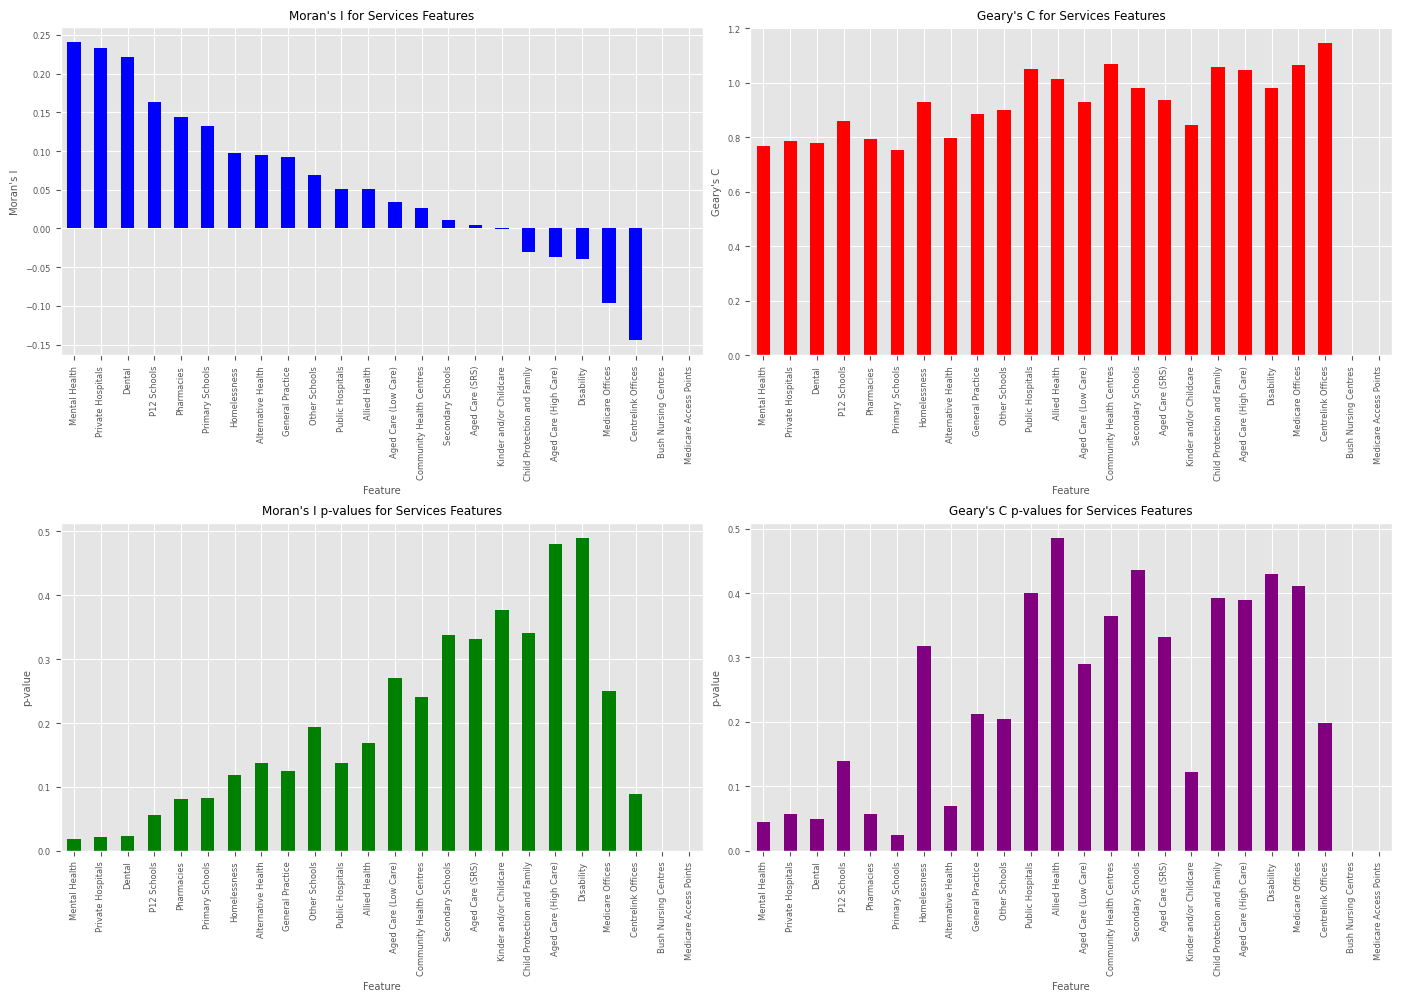

Number of significant Moran's I: 5
Number of significant Geary's C: 5
Features with significant Moran's I:
Index(['Mental Health', 'Private Hospitals', 'Dental', 'Bush Nursing Centres',
       'Medicare Access Points'],
      dtype='object')


Features with significant Geary's C:
Index(['Mental Health', 'Dental', 'Primary Schools', 'Bush Nursing Centres',
       'Medicare Access Points'],
      dtype='object')


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esda import Moran, Geary
from pysal.lib import weights

# Assume 'data', 'feature_category_dict', and spatial weights 'w' are already defined

# Set global font size for all elements
plt.rcParams.update({'font.size': 6})

# Any plot created after this will use the updated font size


# Compute Moran's I and Geary's C for each feature in 'Services'
moran_results = {}
geary_results = {}
moran_p_values = {}
geary_p_values = {}

for feature in feature_category_dict['Services']:
	moran = Moran(data[feature], w, permutations=9999)
	geary = Geary(data[feature], w, permutations=9999)
	moran_results[feature] = moran.I
	geary_results[feature] = geary.C
	moran_p_values[feature] = moran.p_sim
	geary_p_values[feature] = geary.p_sim

# Create a DataFrame for Moran's I, Geary's C, and their p-values
moran_geary_df = pd.DataFrame({
	"Moran's I": moran_results,
	"Geary's C": geary_results,
	"Moran's I p-value": moran_p_values,
	"Geary's C p-value": geary_p_values
})
moran_geary_df = moran_geary_df.sort_values(by="Moran's I", ascending=False)

# Plot Moran's I, Geary's C, and their p-values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Moran's I
moran_geary_df["Moran's I"].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Moran's I for Services Features")
axes[0, 0].set_ylabel("Moran's I")
axes[0, 0].set_xlabel("Feature")
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C
moran_geary_df["Geary's C"].plot(kind='bar', ax=axes[0, 1], color='red')
axes[0, 1].set_title("Geary's C for Services Features")
axes[0, 1].set_ylabel("Geary's C")
axes[0, 1].set_xlabel("Feature")
axes[0, 1].tick_params(axis='x', rotation=90)

# Plot Moran's I p-values
moran_geary_df["Moran's I p-value"].plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Moran's I p-values for Services Features")
axes[1, 0].set_ylabel("p-value")
axes[1, 0].set_xlabel("Feature")
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C p-values
moran_geary_df["Geary's C p-value"].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title("Geary's C p-values for Services Features")
axes[1, 1].set_ylabel("p-value")
axes[1, 1].set_xlabel("Feature")
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

# count number of significant Moran's I and Geary's C
significant_moran = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].shape[0]
significant_geary = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].shape[0]

# print the number of significant Moran's I and Geary's C
print(f'Number of significant Moran\'s I: {significant_moran}')
print(f'Number of significant Geary\'s C: {significant_geary}')

# print the names of the features with significant Moran's I and Geary's C
significant_moran_features = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].index
significant_geary_features = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].index

print('Features with significant Moran\'s I:')
print(significant_moran_features)
print('\n')
print('Features with significant Geary\'s C:')
print(significant_geary_features)


In [33]:
# print the significant Moran's I and Geary's C values
significant_moran_values, significant_moran_p_values = moran_geary_df.loc[significant_moran_features, "Moran's I"], moran_geary_df.loc[significant_moran_features, "Moran's I p-value"]
significant_geary_values, significant_geary_p_values = moran_geary_df.loc[significant_geary_features, "Geary's C"], moran_geary_df.loc[significant_geary_features, "Geary's C p-value"]

print('Significant Moran\'s I values:')
print(significant_moran_values)
print('\n')
print('Significant Moran\'s I p-values:')
print(significant_moran_p_values)
print('-----------------------------------')
print('Significant Geary\'s C values:')
print(significant_geary_values)
print('\n')
print('Significant Geary\'s C p-values:')
print(significant_geary_p_values)


Significant Moran's I values:
Mental Health             0.240601
Private Hospitals         0.232664
Dental                    0.221644
Bush Nursing Centres           NaN
Medicare Access Points         NaN
Name: Moran's I, dtype: float64


Significant Moran's I p-values:
Mental Health             0.0177
Private Hospitals         0.0214
Dental                    0.0230
Bush Nursing Centres      0.0001
Medicare Access Points    0.0001
Name: Moran's I p-value, dtype: float64
-----------------------------------
Significant Geary's C values:
Mental Health             0.766554
Dental                    0.780440
Primary Schools           0.751849
Bush Nursing Centres           NaN
Medicare Access Points         NaN
Name: Geary's C, dtype: float64


Significant Geary's C p-values:
Mental Health             0.0453
Dental                    0.0493
Primary Schools           0.0246
Bush Nursing Centres      0.0001
Medicare Access Points    0.0001
Name: Geary's C p-value, dtype: float64


In [34]:
# compute fraction of significant Moran's I and Geary's C
fraction_significant_moran = significant_moran / len(moran_geary_df)
fraction_significant_geary = significant_geary / len(moran_geary_df)

# print the fraction of significant Moran's I and Geary's C
print(f'Fraction of significant Moran\'s I: {fraction_significant_moran:.2f}')
print(f'Fraction of significant Geary\'s C: {fraction_significant_geary:.2f}')

Fraction of significant Moran's I: 0.21
Fraction of significant Geary's C: 0.21


In [35]:
# weight of the 'services_score' contributed by significant Moran's I and Geary's C
significant_moran_weight = data_services_scaled[significant_moran_features].sum().sum() / (data['suburb_services_score'].sum()*data_services_scaled.shape[1])
significant_geary_weight = data_services_scaled[significant_geary_features].sum().sum() / (data['suburb_services_score'].sum()*data_services_scaled.shape[1])

# print the % weight of the 'services_score' contributed by significant Moran's I and Geary's C
print(f'Weight of significant Moran\'s I in Service Score: {significant_moran_weight:.2%}')
print(f'Weight of significant Geary\'s C in Service Score: {significant_geary_weight:.2%}')

Weight of significant Moran's I in Service Score: 15.25%
Weight of significant Geary's C in Service Score: 19.90%


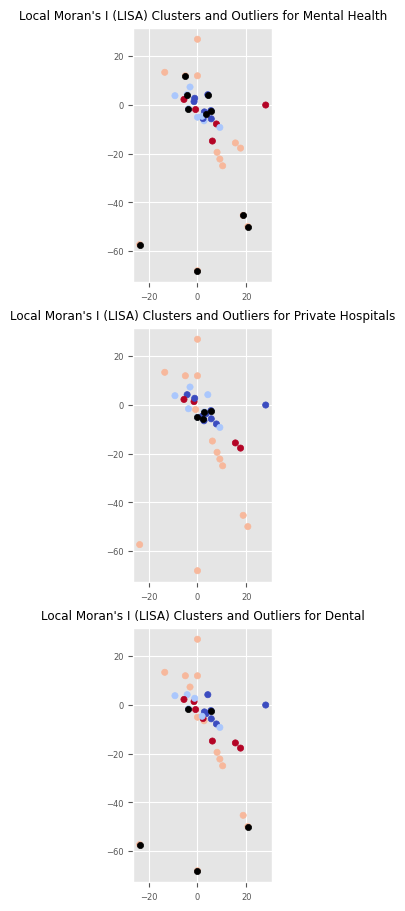

Significant clusters for 'Mental Health' at indices: [ 0  6 16 19 20 21 22 26 30 31]
Significant clusters for 'Private Hospitals' at indices: [7]
Significant clusters for 'Dental' at indices: [19 22 26 30 31]


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import libpysal as ps
from esda.moran import Moran_Local
import geopandas as gpd

# Adjust the function to accept multiple features
def plot_local_moran(data, features, w, coords):
    """
    Plots Local Moran's I statistics for multiple features.
    
    Parameters:
    - data: DataFrame containing the feature columns.
    - features: List of feature column names to calculate Local Moran's I.
    - w: Spatial weights object from libpysal.
    - coords: List of coordinate tuples (x, y).
    """
    # Create a GeoDataFrame for visualization
    gdf_temp = gpd.GeoDataFrame({
        'geometry': [ps.cg.Point(c) for c in coords]
    })
    
    # Set up the figure for multiple subplots
    n_features = len(features)
    fig, axs = plt.subplots(n_features, 1, figsize=(5, 3 * n_features), constrained_layout=True)
    
    # Ensure axs is iterable for a single feature case
    if n_features == 1:
        axs = [axs]
    
    # Iterate over each feature to compute and plot LISA
    for idx, feature in enumerate(features):
        # Calculate Local Moran's I
        lisa = Moran_Local(data[feature], w, permutations=9999)
        
        # Store results in the GeoDataFrame
        gdf_temp['lisa'] = lisa.q
        gdf_temp['significant'] = lisa.p_sim < 0.05  # Identify significant points
        
        # Plot the results, with significant points highlighted
        gdf_temp.plot(
            column='lisa',
            cmap='coolwarm',
            legend=False,
            ax=axs[idx],
            markersize=20
        )
        
        # Plot significant points in black
        gdf_temp[gdf_temp['significant']].plot(
            color='black',
            ax=axs[idx],
            markersize=20
        )
        
        axs[idx].set_title(f"Local Moran's I (LISA) Clusters and Outliers for {feature}")
    
    # Display the plot
    
    plt.show()

    # Output indices of significant clusters for each feature
    for idx, feature in enumerate(features):
        lisa = Moran_Local(data[feature], w, permutations=9999)
        significant_indices = np.where(lisa.p_sim < 0.05)[0]
        print(f"Significant clusters for '{feature}' at indices:", significant_indices)


    

# Example usage:
coord = np.array([[data.iloc[i]['cart_x'], data.iloc[i]['cart_y']] for i in range(len(data))])
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
features = [i for i in significant_moran_features if np.isnan(significant_moran_values[i])==False]
plot_local_moran(data, features, w, coords)


In [37]:
features = [i for i in significant_moran_features if significant_moran_values[i] !=np.float64(None)]

np.isnan(significant_moran_values['Medicare Access Points'])==True

np.True_

## Population Distribution

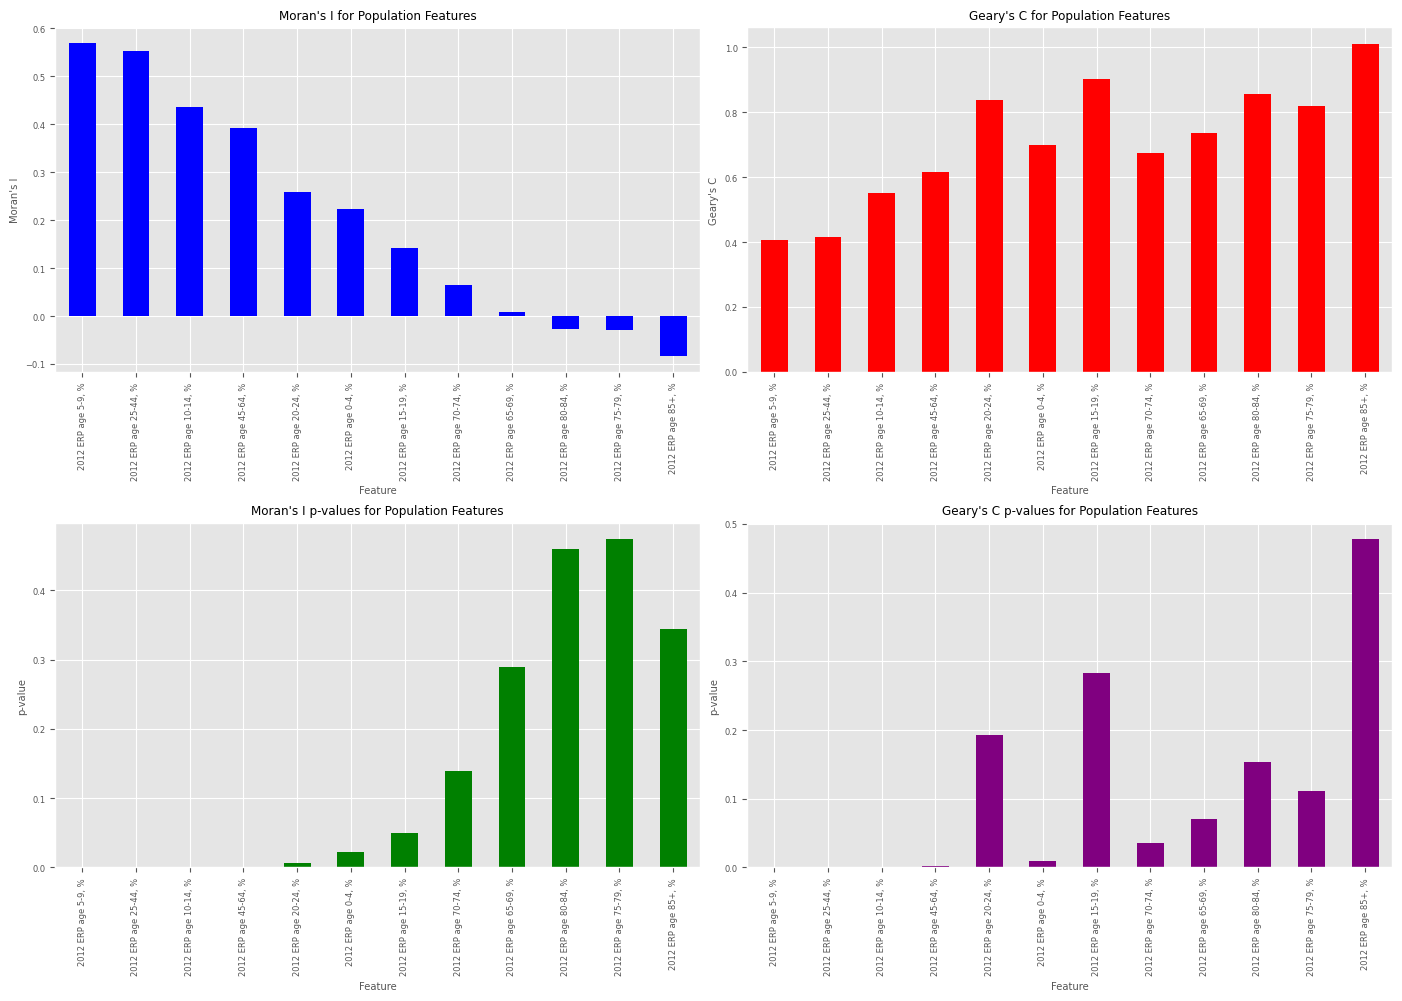

In [38]:
# compute Moran's I and Geary's C for each feature in 'Population'
moran_results = {}
geary_results = {}
moran_p_values = {}
geary_p_values = {}

population_frac_features = data_population_percentage.columns

for feature in population_frac_features:
	moran = Moran(data_population_frac[feature], w, permutations=9999)
	geary = Geary(data_population_frac[feature], w, permutations=9999)
	moran_results[feature] = moran.I
	geary_results[feature] = geary.C
	moran_p_values[feature] = moran.p_sim
	geary_p_values[feature] = geary.p_sim
	
# Create a DataFrame for Moran's I, Geary's C, and their p-values
moran_geary_df = pd.DataFrame({
	"Moran's I": moran_results,
	"Geary's C": geary_results,
	"Moran's I p-value": moran_p_values,
	"Geary's C p-value": geary_p_values
})

moran_geary_df = moran_geary_df.sort_values(by="Moran's I", ascending=False)

# Plot Moran's I, Geary's C, and their p-values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Moran's I
moran_geary_df["Moran's I"].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Moran's I for Population Features")
axes[0, 0].set_ylabel("Moran's I")
axes[0, 0].set_xlabel("Feature")
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C
moran_geary_df["Geary's C"].plot(kind='bar', ax=axes[0, 1], color='red')
axes[0, 1].set_title("Geary's C for Population Features")
axes[0, 1].set_ylabel("Geary's C")
axes[0, 1].set_xlabel("Feature")
axes[0, 1].tick_params(axis='x', rotation=90)

# Plot Moran's I p-values
moran_geary_df["Moran's I p-value"].plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Moran's I p-values for Population Features")
axes[1, 0].set_ylabel("p-value")
axes[1, 0].set_xlabel("Feature")
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C p-values
moran_geary_df["Geary's C p-value"].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title("Geary's C p-values for Population Features")
axes[1, 1].set_ylabel("p-value")
axes[1, 1].set_xlabel("Feature")
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
# count number of significant Moran's I and Geary's C
significant_moran = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].shape[0]
significant_geary = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].shape[0]

# print the number of significant Moran's I and Geary's C
print(f'Number of significant Moran\'s I: {significant_moran}')
print(f'Number of significant Geary\'s C: {significant_geary}')

Number of significant Moran's I: 6
Number of significant Geary's C: 6


In [40]:
# print the names of the features with significant Moran's I and Geary's C
significant_moran_features = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].index
significant_geary_features = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].index

print('Features with significant Moran\'s I:')
print(significant_moran_features)
print('\n')
print('Features with significant Geary\'s C:')
print(significant_geary_features)


Features with significant Moran's I:
Index(['2012 ERP age 5-9, %', '2012 ERP age 25-44, %', '2012 ERP age 10-14, %',
       '2012 ERP age 45-64, %', '2012 ERP age 20-24, %',
       '2012 ERP age 0-4, %'],
      dtype='object')


Features with significant Geary's C:
Index(['2012 ERP age 5-9, %', '2012 ERP age 25-44, %', '2012 ERP age 10-14, %',
       '2012 ERP age 45-64, %', '2012 ERP age 0-4, %',
       '2012 ERP age 70-74, %'],
      dtype='object')


In [41]:
# print the significant Moran's I and Geary's C values
significant_moran_values, significant_moran_p_values = moran_geary_df.loc[significant_moran_features, "Moran's I"], moran_geary_df.loc[significant_moran_features, "Moran's I p-value"]
significant_geary_values, significant_geary_p_values = moran_geary_df.loc[significant_geary_features, "Geary's C"], moran_geary_df.loc[significant_geary_features, "Geary's C p-value"]

print('Significant Moran\'s I values:')
print(significant_moran_values)
print('\n')
print('Significant Moran\'s I p-values:')
print(significant_moran_p_values)
print('-----------------------------------')
print('Significant Geary\'s C values:')
print(significant_geary_values)
print('\n')
print('Significant Geary\'s C p-values:')
print(significant_geary_p_values)

# compute fraction of significant Moran's I and Geary's C
fraction_significant_moran = significant_moran / len(moran_geary_df)
fraction_significant_geary = significant_geary / len(moran_geary_df)

# print the fraction of significant Moran's I and Geary's C
print(f'Fraction of significant Moran\'s I: {fraction_significant_moran:.2f}')
print(f'Fraction of significant Geary\'s C: {fraction_significant_geary:.2f}')


Significant Moran's I values:
2012 ERP age 5-9, %      0.569421
2012 ERP age 25-44, %    0.552594
2012 ERP age 10-14, %    0.435089
2012 ERP age 45-64, %    0.391538
2012 ERP age 20-24, %    0.257946
2012 ERP age 0-4, %      0.222624
Name: Moran's I, dtype: float64


Significant Moran's I p-values:
2012 ERP age 5-9, %      0.0001
2012 ERP age 25-44, %    0.0001
2012 ERP age 10-14, %    0.0001
2012 ERP age 45-64, %    0.0005
2012 ERP age 20-24, %    0.0057
2012 ERP age 0-4, %      0.0227
Name: Moran's I p-value, dtype: float64
-----------------------------------
Significant Geary's C values:
2012 ERP age 5-9, %      0.406201
2012 ERP age 25-44, %    0.416270
2012 ERP age 10-14, %    0.551259
2012 ERP age 45-64, %    0.614411
2012 ERP age 0-4, %      0.697735
2012 ERP age 70-74, %    0.673972
Name: Geary's C, dtype: float64


Significant Geary's C p-values:
2012 ERP age 5-9, %      0.0001
2012 ERP age 25-44, %    0.0001
2012 ERP age 10-14, %    0.0002
2012 ERP age 45-64, %    0.0013
2012

In [42]:
# weight of the 'Population Fractions' contributed by significant Moran's I and Geary's C
significant_moran_weight = data_population_frac[significant_moran_features].sum().sum() / data_population_frac.sum().sum()
significant_geary_weight = data_population_frac[significant_geary_features].sum().sum() / data_population_frac.sum().sum()

# print the % weight of the 'Population Fractions' contributed by significant Moran's I and Geary's C
print(f'Weight of significant Moran\'s I in Population Fractions: {significant_moran_weight:.2%}')
print(f'Weight of significant Geary\'s C in Population Fractions: {significant_geary_weight:.2%}')

union_features=significant_moran_features.union(significant_geary_features)


union_of_significant_features = significant_moran_features.union(significant_geary_features)

# print the % weight of the 'Population Fractions' contributed by significant Moran's I and Geary's C
significant_union_weight = data_population_frac[union_of_significant_features].sum().sum() / data_population_frac.sum().sum()
print(f'Weight of significant Moran\'s I in Population Fractions: {significant_union_weight:.2%}')



Weight of significant Moran's I in Population Fractions: 80.78%
Weight of significant Geary's C in Population Fractions: 75.53%
Weight of significant Moran's I in Population Fractions: 83.77%


In [43]:
# Get the union of significant Moran and Geary features
combined_features = significant_moran_features.union(significant_geary_features)

# Display the result
print(combined_features)


Index(['2012 ERP age 0-4, %', '2012 ERP age 10-14, %', '2012 ERP age 20-24, %',
       '2012 ERP age 25-44, %', '2012 ERP age 45-64, %', '2012 ERP age 5-9, %',
       '2012 ERP age 70-74, %'],
      dtype='object')


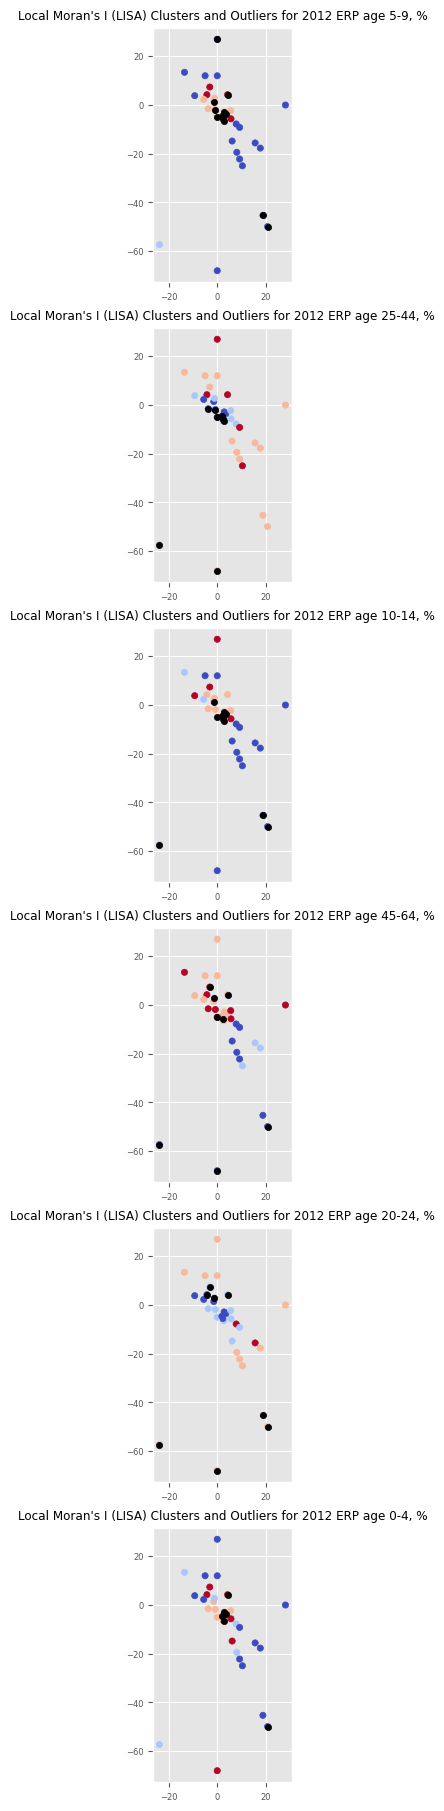

Significant clusters for '2012 ERP age 5-9, %' at indices: [ 2 15 16 19 20 21 23 24 27 28 29 31 33]
Significant clusters for '2012 ERP age 25-44, %' at indices: [19 22 23 26 27 28 29 33]
Significant clusters for '2012 ERP age 10-14, %' at indices: [15 20 21 22 24 27 28 29 31 33]
Significant clusters for '2012 ERP age 45-64, %' at indices: [ 0 16 17 18 22 26 28 29 31]
Significant clusters for '2012 ERP age 20-24, %' at indices: [ 0 16 17 18 22 26 31]
Significant clusters for '2012 ERP age 0-4, %' at indices: [10 16 20 24 27 31 33]


In [44]:
coord = np.array([[data.iloc[i]['cart_x'], data.iloc[i]['cart_y']] for i in range(len(data))])
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
features = [i for i in significant_moran_features if np.isnan(significant_moran_values[i])==False]
plot_local_moran(data, features, w, coords)